# 使用Transformer 中一个架构，即ViT处理分类任务

## 导入需要得库

In [2]:
import os
import math
import numpy as np
import pickle as p
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
from tensorflow.keras import layers
import tensorflow_addons as tfa
%matplotlib inline


## 定义数据加载函数

In [4]:
def load_CIFAR_data(data_dir):
    """load CIFAR data"""
 
    images_train=[]
    labels_train=[]
    for i in range(5):
        f=os.path.join(data_dir,'data_batch_%d' % (i+1))
        print('loading ',f)
        # 调用 load_CIFAR_batch( )获得批量的图像及其对应的标签
        image_batch,label_batch=load_CIFAR_batch(f)
        images_train.append(image_batch)
        labels_train.append(label_batch)
        Xtrain=np.concatenate(images_train)
        Ytrain=np.concatenate(labels_train)
        del image_batch ,label_batch
    
    Xtest,Ytest=load_CIFAR_batch(os.path.join(data_dir,'test_batch'))
    print('finished loadding CIFAR-10 data')
    
    # 返回训练集的图像和标签，测试集的图像和标签
    return (Xtrain,Ytrain),(Xtest,Ytest)


In [5]:
def load_CIFAR_batch(filename):
    """ load single batch of cifar """  
    with open(filename, 'rb')as f:
        # 一个样本由标签和图像数据组成
        # <1 x label><3072 x pixel> (3072=32x32x3)
        # ...
        # <1 x label><3072 x pixel>
        data_dict = p.load(f, encoding='bytes')
        images= data_dict[b'data']
        labels = data_dict[b'labels']
                
        # 把原始数据结构调整为: BCWH
        images = images.reshape(10000, 3, 32, 32)
        # tensorflow处理图像数据的结构：BWHC
        # 把通道数据C移动到最后一个维度
        images = images.transpose (0,2,3,1)     
        labels = np.array(labels)
        
        return images, labels


In [6]:
data_dir = '../data/cifar-10-batches-py'
(x_train,y_train),(x_test,y_test) = load_CIFAR_data(data_dir)


loading  ../data/cifar-10-batches-py\data_batch_1
loading  ../data/cifar-10-batches-py\data_batch_2
loading  ../data/cifar-10-batches-py\data_batch_3
loading  ../data/cifar-10-batches-py\data_batch_4
loading  ../data/cifar-10-batches-py\data_batch_5
finished loadding CIFAR-10 data


## 对数据进行预处理

In [7]:
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
test_dataset = tf.data.Dataset.from_tensor_slices((x_test, y_test))


In [8]:
num_classes = 10
input_shape = (32, 32, 3)

learning_rate = 0.001
weight_decay = 0.0001
batch_size = 256
num_epochs = 10
image_size = 72  # We'll resize input images to this size
patch_size = 6  # Size of the patches to be extract from the input images
num_patches = (image_size // patch_size) ** 2
projection_dim = 64
num_heads = 4
transformer_units = [
    projection_dim * 2,
    projection_dim,
]  # Size of the transformer layers
transformer_layers = 8
mlp_head_units = [2048, 1024]  # Size of the dense layers of the final classifier


In [9]:
data_augmentation = keras.Sequential(
    [
        layers.experimental.preprocessing.Normalization(),
        layers.experimental.preprocessing.Resizing(image_size, image_size),
        layers.experimental.preprocessing.RandomFlip("horizontal"),
        layers.experimental.preprocessing.RandomRotation(factor=0.02),
        layers.experimental.preprocessing.RandomZoom(
            height_factor=0.2, width_factor=0.2
        ),
    ],
    name="data_augmentation",
)
# 使预处理层的状态与正在传递的数据相匹配
#Compute the mean and the variance of the training data for normalization.
data_augmentation.layers[0].adapt(x_train)

## 构建模型

In [10]:
def mlp(x, hidden_units, dropout_rate):
    for units in hidden_units:
        x = layers.Dense(units, activation=tf.nn.gelu)(x)
        x = layers.Dropout(dropout_rate)(x)
    return x


In [11]:
class Patches(layers.Layer):
    def __init__(self, patch_size):
        super(Patches, self).__init__()
        self.patch_size = patch_size

    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding="VALID",
        )
        patch_dims = patches.shape[-1]
        patches = tf.reshape(patches, [batch_size, -1, patch_dims])
        return patches


Image size: 72 X 72
Patch size: 6 X 6
Patches per image: 144
Elements per patch: 108


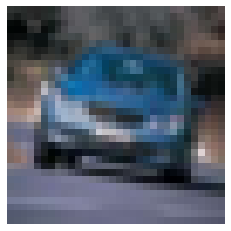

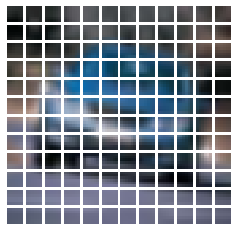

In [12]:
import matplotlib.pyplot as plt

plt.figure(figsize=(4, 4))
image = x_train[np.random.choice(range(x_train.shape[0]))]
plt.imshow(image.astype("uint8"))
plt.axis("off")

resized_image = tf.image.resize(
    tf.convert_to_tensor([image]), size=(image_size, image_size)
)
patches = Patches(patch_size)(resized_image)
print(f"Image size: {image_size} X {image_size}")
print(f"Patch size: {patch_size} X {patch_size}")
print(f"Patches per image: {patches.shape[1]}")
print(f"Elements per patch: {patches.shape[-1]}")

n = int(np.sqrt(patches.shape[1]))
plt.figure(figsize=(4, 4))
for i, patch in enumerate(patches[0]):
    ax = plt.subplot(n, n, i + 1)
    patch_img = tf.reshape(patch, (patch_size, patch_size, 3))
    plt.imshow(patch_img.numpy().astype("uint8"))
    plt.axis("off")


In [13]:
class PatchEncoder(layers.Layer):
    def __init__(self, num_patches, projection_dim):
        super(PatchEncoder, self).__init__()
        self.num_patches = num_patches
        #一个全连接层，其输出维度为projection_dim，没有指明激活函数
        self.projection = layers.Dense(units=projection_dim)
        #定义一个嵌入层，这是一个可学习的层
        #输入维度为num_patches，输出维度为projection_dim
        self.position_embedding = layers.Embedding(
            input_dim=num_patches, output_dim=projection_dim
        )

    def call(self, patch):
        positions = tf.range(start=0, limit=self.num_patches, delta=1)
        encoded = self.projection(patch) + self.position_embedding(positions)
        return encoded


In [15]:
def create_vit_classifier():
    inputs = layers.Input(shape=input_shape)
    # Augment data.
    augmented = data_augmentation(inputs)
    #augmented = augmented_train_batches(inputs)    
    # Create patches.
    patches = Patches(patch_size)(augmented)
    # Encode patches.
    encoded_patches = PatchEncoder(num_patches, projection_dim)(patches)

    # Create multiple layers of the Transformer block.
    for _ in range(transformer_layers):
        # Layer normalization 1.
        x1 = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
        # Create a multi-head attention layer.
        attention_output = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=projection_dim, dropout=0.1
        )(x1, x1)
        # Skip connection 1.
        x2 = layers.Add()([attention_output, encoded_patches])
        # Layer normalization 2.
        x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
        # MLP.
        x3 = mlp(x3, hidden_units=transformer_units, dropout_rate=0.1)
        # Skip connection 2.
        encoded_patches = layers.Add()([x3, x2])

    # Create a [batch_size, projection_dim] tensor.
    representation = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
    representation = layers.Flatten()(representation)
    representation = layers.Dropout(0.5)(representation)
    # Add MLP.
    features = mlp(representation, hidden_units=mlp_head_units, dropout_rate=0.5)
    # Classify outputs.
    logits = layers.Dense(num_classes)(features)
    # Create the Keras model.
    model = keras.Model(inputs=inputs, outputs=logits)
    return model


## 编译并训练模型

In [16]:
def run_experiment(model):
    optimizer = tfa.optimizers.AdamW(
        learning_rate=learning_rate, weight_decay=weight_decay
    )

    model.compile(
        optimizer=optimizer,
        loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=[
            keras.metrics.SparseCategoricalAccuracy(name="accuracy"),
            keras.metrics.SparseTopKCategoricalAccuracy(5, name="top-5-accuracy"),
        ],
    )

    #指定保存模型的路径
    checkpoint_filepath ="model_bak.hdf5"
    checkpoint_callback = keras.callbacks.ModelCheckpoint(
        checkpoint_filepath,
        monitor="val_accuracy",
        save_best_only=True,
        save_weights_only=True,
    )

    history = model.fit(
        x=x_train,
        y=y_train,
        batch_size=batch_size,
        epochs=num_epochs,
        validation_split=0.1,
        callbacks=[checkpoint_callback],
    )

    model.load_weights(checkpoint_filepath)
    _, accuracy, top_5_accuracy = model.evaluate(x_test, y_test)
    print(f"Test accuracy: {round(accuracy * 100, 2)}%")
    print(f"Test top 5 accuracy: {round(top_5_accuracy * 100, 2)}%")

    return history


In [17]:
vit_classifier = create_vit_classifier()
history = run_experiment(vit_classifier)


Epoch 1/10
176/176 [==============================] - 67s 327ms/step - loss: 2.7724 - accuracy: 0.2569 - top-5-accuracy: 0.7412 - val_loss: 1.4837 - val_accuracy: 0.4660 - val_top-5-accuracy: 0.9132
Epoch 2/10
176/176 [==============================] - 57s 323ms/step - loss: 1.5941 - accuracy: 0.4256 - top-5-accuracy: 0.8981 - val_loss: 1.3090 - val_accuracy: 0.5294 - val_top-5-accuracy: 0.9436
Epoch 3/10
176/176 [==============================] - 57s 325ms/step - loss: 1.4189 - accuracy: 0.4935 - top-5-accuracy: 0.9225 - val_loss: 1.1318 - val_accuracy: 0.5818 - val_top-5-accuracy: 0.9580
Epoch 4/10
176/176 [==============================] - 57s 323ms/step - loss: 1.3096 - accuracy: 0.5342 - top-5-accuracy: 0.9342 - val_loss: 1.1104 - val_accuracy: 0.6096 - val_top-5-accuracy: 0.9588
Epoch 5/10
176/176 [==============================] - 57s 322ms/step - loss: 1.2394 - accuracy: 0.5580 - top-5-accuracy: 0.9452 - val_loss: 1.0018 - val_accuracy: 0.6462 - val_top-5-accuracy: 0.9690
Epoch

## 可视化运行结果

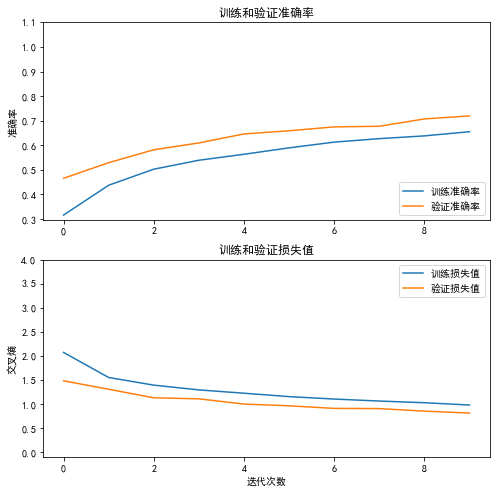

In [19]:
plt.rcParams['font.sans-serif']=['SimHei']
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
 
loss = history.history['loss']
val_loss =history.history['val_loss']
 
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='训练准确率')
plt.plot(val_acc, label='验证准确率')
plt.legend(loc='lower right')
plt.ylabel('准确率')
plt.ylim([min(plt.ylim()),1.1])
plt.title('训练和验证准确率')
 
plt.subplot(2, 1, 2)
plt.plot(loss, label='训练损失值')
plt.plot(val_loss, label='验证损失值')
plt.legend(loc='upper right')
plt.ylabel('交叉熵')
plt.ylim([-0.1,4.0])
plt.title('训练和验证损失值')
plt.xlabel('迭代次数')
plt.show()
